## Imports

In [1]:
import os, sys
currentdir = os.path.dirname(os.path.realpath("mandril.ipynb"))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

import numpy as np
import gym
import torch
import json
import numpy as np
from tqdm import trange

import maml_rl.envs
from maml_rl.baseline import LinearFeatureBaseline
from maml_rl.samplers import MultiTaskSampler
from maml_rl.utils.helpers import get_policy_for_env, get_input_size
from maml_rl.utils.reinforcement_learning import get_returns, reinforce_loss

from mazelab import MazeEnv
from mazelab.solvers import dijkstra_solver

In [2]:
def show_maze(maze, title=None):
    fig = plt.figure(figsize=(8,8))
    plt.imshow(maze)
    if title:
        plt.title(title)
    plt.show()

In [3]:
with np.load("../maml-randomShapeMaze/results.npz") as data_file:
    logs = {
        "tasks": data_file["tasks"],
        "train_returns" : data_file["train_returns"],
        "valid_returns" : data_file["valid_returns"],
        # "train_episodes" : data_file["train_episodes"],
        # "valid_episodes" : data_file["valid_episodes"],
    }

In [4]:
display(logs["tasks"].shape)
display(logs["train_returns"].shape)
display(logs["valid_returns"].shape)

(160, 10, 10)

(160, 20)

(160, 20)

In [5]:
display(logs["tasks"][0])
display(np.mean(logs["train_returns"],1))
display(np.mean(logs["valid_returns"],1))

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 1, 1, 0, 0, 0, 0, 1],
       [1, 0, 1, 1, 1, 0, 0, 0, 0, 1],
       [1, 0, 1, 1, 0, 1, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 1, 1, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

array([0.949     , 0.9455    , 0.959     , 0.95250005, 0.9534999 ,
       0.95150006, 0.9425001 , 0.959     , 0.954     , 0.96449995,
       0.95800006, 0.9585    , 0.94850004, 0.96400005, 0.96049994,
       0.94700015, 0.9400002 , 0.9445001 , 0.9500001 , 0.96150005,
       0.9549999 , 0.94299996, 0.95250005, 0.949     , 0.952     ,
       0.95300007, 0.9685    , 0.959     , 0.9370001 , 0.95600003,
       0.9610001 , 0.9495001 , 0.9674999 , 0.96050006, 0.9625    ,
       0.95150006, 0.9505    , 0.96049994, 0.95500004, 0.95      ,
       0.9415    , 0.962     , 0.952     , 0.939     , 0.9525    ,
       0.9535001 , 0.9495001 , 0.94949996, 0.96449995, 0.9495001 ,
       0.96099997, 0.94750005, 0.95199996, 0.9655    , 0.95250005,
       0.9525    , 0.95300007, 0.947     , 0.96099985, 0.94700015,
       0.9570001 , 0.95050013, 0.9410001 , 0.95      , 0.9525    ,
       0.9535    , 0.949     , 0.9415    , 0.9585    , 0.95800006,
       0.9545    , 0.95600003, 0.9595    , 0.94350016, 0.94750

array([ -59.415   ,  -73.261   , -178.36201 ,  -28.408005,  -93.9115  ,
        -70.1025  ,  -39.222504,  -23.130001,  -49.669   ,  -67.8715  ,
       -195.96852 ,  -74.5085  ,  -99.995995,  -58.670006,  -12.6795  ,
        -49.594   ,  -71.687996,  -41.2935  , -186.1215  ,  -43.803505,
        -51.191498,  -76.48399 ,  -78.082   ,  -65.6845  ,  -45.039   ,
        -44.966007,  -72.1815  ,  -59.55351 ,  -77.6255  ,  -72.52    ,
        -72.217   ,  -60.091503,  -81.5265  ,  -59.8485  , -165.7825  ,
        -69.309494,  -89.30501 ,  -43.521503,  -54.65101 ,  -63.5765  ,
        -61.4805  , -125.93251 ,  -84.54849 ,  -49.452003,  -67.47749 ,
        -91.1265  ,  -48.8585  ,  -75.3885  ,  -54.754498,  -48.762997,
        -39.6535  ,  -42.536003,  -64.007996,  -89.25351 ,  -30.601002,
       -167.46251 ,  -51.392494, -173.7165  , -110.351   ,  -51.441994,
        -69.764   ,  -80.493   ,  -52.127502,  -36.185505, -165.63303 ,
       -146.43301 ,  -63.273003, -119.25452 ,  -87.22101 ,  -79.

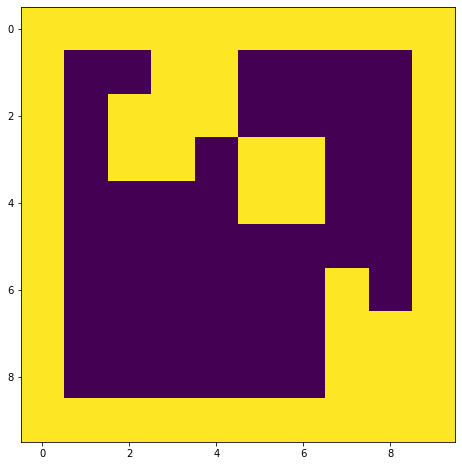

In [6]:
import matplotlib.pyplot as plt

x = logs["tasks"][0]
show_maze(x)

In [7]:
import argparse
parser = argparse.ArgumentParser(
    description='Reinforcement learning with Model-Agnostic Meta-Learning (MAML) - Test')

args = {
"config": "../maml-randomShapeMaze/config.json",
"policy": "../maml-randomShapeMaze/policy.th",

# Evaluation
"num_batches": 1,
"meta_batch_size": 1,

# Miscellaneous
"output": "maml-randomShapeMaze/results.npz",
"seed": None,
"num_workers": 1,
"device": ('cpu'),
}

height = 10
width = 10

In [8]:
try:
    gym.envs.register(
        id="RandomShapeMaze-v0",
        entry_point=MazeEnv,
        max_episode_steps=200,
        kwargs={"width": 10, "height": 10, "max_shapes": 5,
                "max_size": 2, "allow_overlap": False, "shape": None}
    )
except:
    print("environment already registered")

In [9]:
with open(args["config"], 'r') as f:
    config = json.load(f)
    if 'env-kwargs' not in config.keys(): config['env-kwargs'] = {}

env = gym.make(config['env-name'], **config['env-kwargs'])
env.close()

# configs:
fast_lr = config["fast-lr"]

In [10]:
def get_policy(policy_path):
    policy = get_policy_for_env(env,
                                hidden_sizes=config['hidden-sizes'],
                                nonlinearity=config['nonlinearity'])
    with open(policy_path, 'rb') as f:
        state_dict = torch.load(f, map_location=torch.device(args["device"]))
        policy.load_state_dict(state_dict)
    return policy
        
policy = get_policy(args["policy"])
print(policy.layer1.bias)#.params["layer1.bias"])

Parameter containing:
tensor([ 0.9675,  0.0920,  3.1693,  0.3888,  0.5249,  0.1662, -0.1650,  1.6500,
         1.0579,  0.3223,  1.8217,  1.7870,  1.2980,  0.6766,  0.6279,  1.3287],
       requires_grad=True)


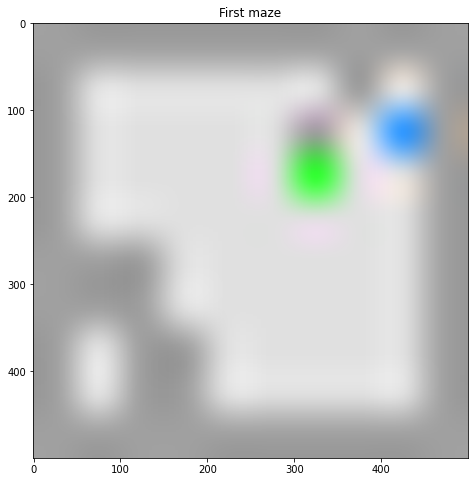

In [11]:
observations = env.reset()
img = env.render('rgb_array')
show_maze(img, "First maze")

In [12]:
def run_policy(env, observations=None, params=None):
    if observations.all == None:
        observations = env.reset()
    data = []
    path = [env.maze.objects.agent.positions[0]]
    count = 0
    reward = 0
    with torch.no_grad():
        while not (env.maze.objects.agent.positions == env.maze.objects.goal.positions) and count < 50:
            observations_tensor = torch.from_numpy(observations)
            pi = policy(observations_tensor, params=params)
            actions_tensor = pi.sample()
            actions = actions_tensor.cpu().numpy()
            print(actions[0])

            new_observations, rewards, _, infos = env.step(actions[0])

            data.append({ "observations": observations, "actions": actions, "rewards": rewards })
            observations = np.expand_dims(new_observations, 0)
            path.append(env.maze.objects.agent.positions[0])
            count += 1
            reward += rewards
    return data, np.array(path), reward

In [13]:
def show_policy(env, params, title):
    observations = env.reset()
    maze_original = observations.reshape(height,width)
    data, path, reward = run_policy(env, observations, params)

    maze_original[path[:,0], path[:,1]] = 4
    maze_original[path[0,0], path[0,1]] = 2
    maze_original[path[-1,0], path[-1,1]] = 3
    show_maze(maze_original, title + " - reward = {0}".format(round(reward, 2)))

In [14]:
observations2 = (observations.astype(float)[None,:,:])
display(observations)
display(observations2)

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 2, 1],
       [1, 0, 0, 0, 0, 0, 3, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 1, 0, 0, 0, 0, 0, 1],
       [1, 0, 1, 1, 0, 0, 0, 0, 0, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=uint8)

array([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 0., 0., 0., 1., 0., 1.],
        [1., 0., 0., 0., 0., 0., 1., 0., 2., 1.],
        [1., 0., 0., 0., 0., 0., 3., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
        [1., 0., 1., 1., 0., 0., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]])

1
1
1
1
1
1
2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3
2
3


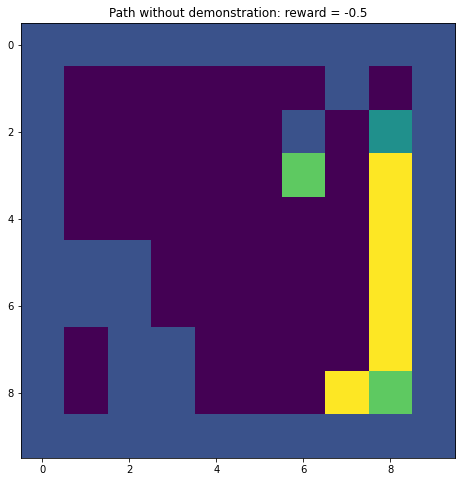

In [15]:
maze_original = observations.reshape(height,width)
data, path, reward = run_policy(env, observations[None,:,:].astype('float32'))

maze_original[path[:,0], path[:,1]] = 4
maze_original[path[0,0], path[0,1]] = 2
maze_original[path[-1,0], path[-1,1]] = 3
show_maze(maze_original, "Path without demonstration: reward = {0}".format(round(reward, 2)))

## Update with example:

In [16]:
class Episodes:
    def __init__(self, batch_size, actions, rewards, observations):
        self.batch_size = batch_size
        self.actions = actions
        self.rewards = rewards
        self.observations = observations
        self.observation_shape = observations.shape[2:]
        self._lengths = None
        
    @property
    def lengths(self):
        if self._lengths is None:
            self._lengths = [len(rewards) for rewards in self.rewards]
        return self._lengths
    
    def __len__(self):
        return max(self.lengths)

In [21]:
def train_iter(policy, params=None):
    observations = env.reset()
    maze_image = env.get_image()
    impassable_array = env.unwrapped.maze.to_impassable()
    motions = env.unwrapped.motions
    start = env.unwrapped.maze.objects.agent.positions[0]
    goal = env.unwrapped.maze.objects.goal.positions[0]
    actions = dijkstra_solver(impassable_array, motions, start, goal)
    rewards = []
    observations = []
    for action in actions:
        observation, reward, _, infos = env.step(action)
        rewards.append(reward)
        observations.append(observation)
        
    actions      = torch.tensor([actions])
    rewards      = torch.tensor([rewards])
    observations = torch.tensor([observations])
    
    episodes = Episodes(1, actions, rewards, observations)
    
    loss = reinforce_loss(policy, episodes, params=params)
    params = policy.update_params(loss,
                                  params=params,
                                  step_size=fast_lr,
                                  first_order=True)
    print(np.array(sum(rewards[0])))
    show_maze(maze_image, "dijkstra - reward = {0}".format(np.round(np.array(sum(rewards[0])), 2)))
    return params

0.95


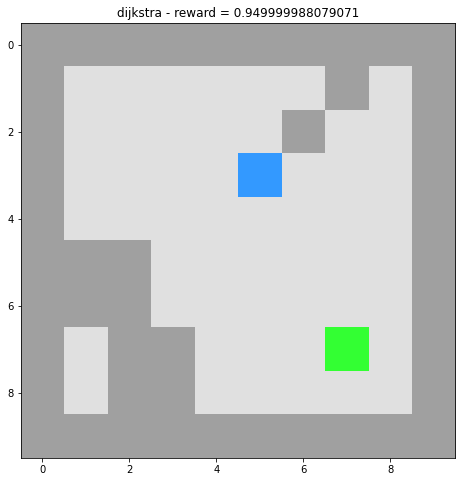

In [22]:
params1 = train_iter(policy)

## Check outcome after 1 iteration:

In [23]:
show_policy(env, params1, "Path after 1 demonstration")

IndexError: tuple index out of range

## After 20 iterations

In [ ]:
params2 = params1
for ii in range(1):
    print(params2["layer3.bias"])
    params2 = train_iter(policy, params2)

show_policy(env, params2, "Path after 10 demonstrations")